### Mi primer AutoEncoder con Keras

En este notebook vamos a ver cómo podemos implementar un autoencoder paso a paso. Todos los ejemplos están extraídos del propio blog de Keras, aquí tenéis el [enlace](https://blog.keras.io/building-autoencoders-in-keras.html) para su consulta.

Comenzemos recordando qué es un autoencoder. Para ello, mirad la imagen siguiente:

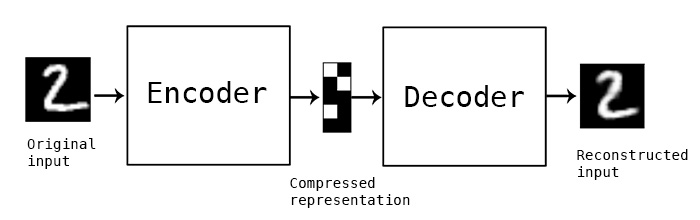

En ella podemos observar como consta de dos bloques: el encoder y el decoder. 

Por una parte, el **encoder** toma los datos de entrada y los comprime en una representación mucho más compacta. 

Por la otra, el **decoder** coge esa representación (o codificación) comprimida y trata de reconstruir los datos originales con el menor error posible.

A lo largo de esta práctica haremos lo siguiente:

* Empezaremos con un AutoEncoder muy simple, en el que tanto el encoder como el decoder tendrán una sola capa Densa.
* Complicaremos un poco más la arquitectura añadiendo más capas
* Cambiaremos la arquitectura para hacer uso de capas convolucionales
* Usaremos el AE convolucional para reducir el ruido presente en nuestras imágenes


**¡Comenzemos!**

Vamos a construir el AutoEncoder más simple posible:

In [ ]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [ ]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [ ]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))

# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

¡Fijaos lo fácil que ha sido, ya tenemos nuestro primer autoencoder funcionando!

Además, tal y como vimos en el video de Geoffrey Hinton "[From PCA to autoencoders](https://www.youtube.com/watch?v=PSOt7u8u23w)", lo que está ocurriendo es que el autoencoder está calculando una representación comprimida de los datos (lo que obtenemos a la salida del encoder) que no es otra cosa que una aproximación a lo que obtendríamos si aplicásemos una PCA. Si no sabéis de lo que estamos hablando, os recomiendo que veáis el video anterior.

Vamos a complicar un poco el asunto. Vamos a convertir nuestro autoencoder en un **deep** autoencoder. ¿Cómo? Añadiendo más capas al encoder y al decoder.

Mirad:

In [ ]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [ ]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Fijaos en cómo las pérdidas que obtenemos ahora son un poco mejores: de ~0.09 que obteníamos antes en validación, a ~0.08.

Veamos los nuevos resultados:

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Además, podemos también mirar las representaciones obtenidas por el encoder, las cuales tienen unas dimensiones de 8x8x4.

Para poder visualizarlas en 2D, las redimensionaremos a 4x32.

In [ ]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

In [ ]:
encoded_imgs.shape

In [ ]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

En teoría, en estas representaciones se encuentra la información necesaria para reconstruir los datos originales con el menor error posible.

Y son estas representaciones las que utilizaremos para clusterizar los datos.